In [1]:
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import steamspypi
import steamreviews
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



load_dotenv()
API_KEY = os.getenv("API_KEY")


In [2]:
import networkx

In [9]:
Networks = []

In [10]:
files = os.listdir("Networks_100_1000")

for file in files:
    id = file.split(".")[0]
    G = nx.read_pajek(f"Networks_100_1000\{file}")
    G = nx.Graph(G)
    if G.number_of_nodes() == 0:
        continue
    Networks.append(G)

In [11]:
com = nx.community.fast_label_propagation_communities(Networks[0])

In [22]:
top_level_communities = next(com)
# next_level_communities = next(com)

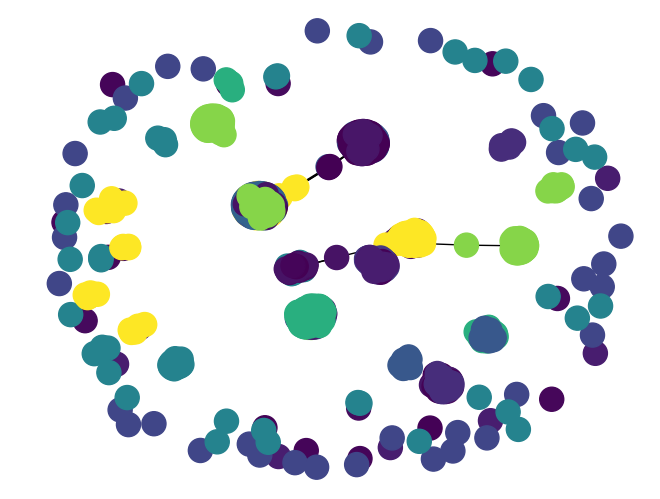

In [14]:
import matplotlib.pyplot as plt

# Generate the communities
communities = nx.community.fast_label_propagation_communities(Networks[9])

# Create a color map
color_map = []
for community in communities:
    for node in community:
        color_map.append(len(community))  # or choose your own way to color them

# Draw the graph
nx.draw(Networks[9], node_color=color_map, with_labels=False)
plt.show()

In [15]:
communities = nx.community.fast_label_propagation_communities(Networks[6])
communities = list(communities)

# Print the number of communities
print("Number of communities:", len(communities))

Number of communities: 126


In [16]:
all_communities = []

for network in Networks:
    communities = nx.community.fast_label_propagation_communities(network)
    communities = list(communities)
    all_communities.append(communities)

# Now all_communities[i] is a list of communities for Networks[i]

In [17]:
from collections import Counter

In [18]:
data_request = {"request": "top100owned"}
data = steamspypi.download(data_request)
df = pd.DataFrame(data.values())
df = df[['name', 'appid']]
display(df.head())

,name,appid
0,Dota 2,570
1,Counter-Strike: Global Offensive,730
2,PUBG: BATTLEGROUNDS,578080
3,New World,1063730
4,Palworld,1623730


In [21]:
directory = 'Networks_100_1000'

# Function to check if a network file exists for a given appid
def network_exists(appid):
    filename = os.path.join(directory, str(appid) + '.net')
    return os.path.exists(filename)

In [22]:
mask = df['appid'].apply(network_exists)
mask

0      True
1      True
2      True
3      True
4      True
      ...  
95    False
96    False
97    False
98     True
99    False
Name: appid, Length: 100, dtype: bool

In [24]:
df

,name,appid
0,Dota 2,570
1,Counter-Strike: Global Offensive,730
2,PUBG: BATTLEGROUNDS,578080
3,New World,1063730
4,Palworld,1623730
...,...,...
95,DayZ,221100
96,Dota Underlords,1046930
97,Risk of Rain 2,632360
98,Robocraft,301520


In [128]:
df = df.reset_index(drop=True)

In [25]:
# Use the mask to filter the DataFrame
df = df[mask]

display(df)

,name,appid
0,Dota 2,570
1,Counter-Strike: Global Offensive,730
2,PUBG: BATTLEGROUNDS,578080
3,New World,1063730
4,Palworld,1623730
...,...,...
80,Sid Meier's Civilization V,8930
81,Life is Strange 2,532210
82,EA SPORTS FIFA 23,1811260
84,Human Fall Flat,477160


In [26]:
def get_tags(appid):
    data_request = {"request": "appdetails", "appid": appid}
    data = steamspypi.download(data_request)
    return data['tags']

df['tags'] = df['appid'].apply(get_tags)

print(df)

                                name    appid  \
0                             Dota 2      570   
1   Counter-Strike: Global Offensive      730   
2                PUBG: BATTLEGROUNDS   578080   
3                          New World  1063730   
4                           Palworld  1623730   
..                               ...      ...   
80        Sid Meier's Civilization V     8930   
81                 Life is Strange 2   532210   
82                 EA SPORTS FIFA 23  1811260   
84                   Human Fall Flat   477160   
98                         Robocraft   301520   

                                                 tags  
0   {'Free to Play': 59570, 'MOBA': 19969, 'Multip...  
1   {'FPS': 90094, 'Shooter': 64803, 'Multiplayer'...  
2   {'Survival': 14610, 'Shooter': 12478, 'Battle ...  
3   {'Open World': 775, 'Massively Multiplayer': 7...  
4   {'Open World': 1002, 'Multiplayer': 999, 'Crea...  
..                                                ...  
80  {'Turn-Based St

D:\tmp\ipykernel_9352\1263462170.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tags'] = df['appid'].apply(get_tags)


In [43]:
from tqdm import tqdm

In [27]:
#sor the df by appid
df = df.sort_values(by='appid')

In [28]:
# Get the tags for each game
df['tags'] = df['appid'].apply(get_tags)

In [36]:
# drop rows with nan values
df = df.dropna()

In [32]:
df= df.reset_index(drop=True)

In [38]:
df.shape

(72, 4)

In [39]:
# Initialize a Counter to keep track of community frequencies
community_counter = Counter()

# Initialize dictionaries to keep track of community sizes and percentages
community_sizes = {}
community_percentages = {}

# Iterate through each network and its corresponding row in the DataFrame
for network, (_, row) in zip(Networks, df.iterrows()):
    # Compute the communities for this network
    communities = nx.community.fast_label_propagation_communities(network)
    communities = list(communities)

    # Update the community counter with the number of communities
    community_counter[len(communities)] += 1

    # Add the number of communities to the DataFrame
    df.loc[row.name, 'num_communities'] = len(communities)

    # Compute the size of each community (number of nodes)
    community_sizes[row.name] = [len(c) for c in communities]

    # Compute the percentage of the total size for each community
    total_size = len(network.nodes())
    community_percentages[row.name] = [(len(c) / total_size) * 100 for c in communities]



In [40]:
# Get all unique tags
all_tags = set()
for tags in df['tags']:
    all_tags.update(tags.keys())

# Now, for each tag, compute the average number of communities, average community size, and average % of total size for games with that tag
tag_community_counts = {}
tag_community_sizes = {}
tag_community_percentages = {}

for tag in all_tags:
    # Get the rows that contain this tag
    rows_with_tag = df[df['tags'].apply(lambda tags: tag in tags.keys())]

    # Compute the average number of communities for these rows
    avg_communities = rows_with_tag['num_communities'].mean()

    # Compute the average community size for these rows
    avg_community_size = np.mean([size for row in rows_with_tag.index for size in community_sizes[row]])

    # Compute the average % of total size for these rows
    avg_percentage = np.mean([percentage for row in rows_with_tag.index for percentage in community_percentages[row]])

    # Store the results
    tag_community_counts[tag] = avg_communities
    tag_community_sizes[tag] = avg_community_size
    tag_community_percentages[tag] = avg_percentage

In [41]:
community_counter.keys()

dict_keys([99, 120, 125, 118, 119, 114, 36, 117, 65, 124, 127, 66, 63, 131, 24, 116, 95, 115, 132, 123, 121, 113, 39, 50, 44, 71, 128, 45, 106, 31, 37, 53, 138, 33, 130, 122, 111])

In [42]:
# Print the results
for tag in tag_community_counts.keys():
    avg_communities = tag_community_counts[tag]
    avg_community_size = tag_community_sizes[tag]
    avg_percentage = tag_community_percentages[tag]
    print(f"Games with the tag '{tag}' have an average of {round(avg_communities, 2)} communities, "
          f"average community size of {round(avg_community_size, 2)} and "
          f"{round(avg_percentage, 2)}% of the total size.")

Games with the tag 'Controller' have an average of 106.67 communities, average community size of 9.38 and 0.94% of the total size.
Games with the tag 'Supernatural' have an average of 130.0 communities, average community size of 7.69 and 0.77% of the total size.
Games with the tag '4 Player Local' have an average of 125.5 communities, average community size of 7.97 and 0.8% of the total size.
Games with the tag 'Dungeon Crawler' have an average of 103.0 communities, average community size of 9.71 and 0.97% of the total size.
Games with the tag 'Sandbox' have an average of 87.35 communities, average community size of 11.45 and 1.14% of the total size.
Games with the tag 'Choose Your Own Adventure' have an average of 125.0 communities, average community size of 8.0 and 0.8% of the total size.
Games with the tag 'Space' have an average of 130.5 communities, average community size of 7.66 and 0.77% of the total size.
Games with the tag 'Silent Protagonist' have an average of 119.0 communit

In [43]:
#get me the top 5 tags with the highest average number of communities and the top 5 tags with the lowest average number of communities
# sorted_tags = sorted(tag_community_counts.items(), key=lambda x: x[1])
sorted_tags = sorted(tag_community_percentages.items(), key=lambda x: x[1])
top_5 = sorted_tags[-25:]
bottom_5 = sorted_tags[:15]

print("Top 5 tags with the highest average number of communities:")
for tag, avg_communities in top_5:
    avg_size = tag_community_sizes[tag]
    avg_percent = tag_community_percentages[tag]
    print(f"Games with the tag '{tag}' have an average of {round(avg_communities, 2)} communities, "
          f"with an average community size of {round(avg_size, 2)} and "
          f"making up an average of {round(avg_percent, 2)}% of the total size.")

print("\nTop 5 tags with the lowest average number of communities:")
for tag, avg_communities in bottom_5:
    avg_size = tag_community_sizes[tag]
    avg_percent = tag_community_percentages[tag]
    print(f"Games with the tag '{tag}' have an average of {round(avg_communities, 2)} communities, "
          f"with an average community size of {round(avg_size, 2)} and "
          f"making up an average of {round(avg_percent, 2)}% of the total size.")

Top 5 tags with the highest average number of communities:
Games with the tag 'Relaxing' have an average of 1.18 communities, with an average community size of 11.83 and making up an average of 1.18% of the total size.
Games with the tag 'Split Screen' have an average of 1.18 communities, with an average community size of 11.83 and making up an average of 1.18% of the total size.
Games with the tag '3D Platformer' have an average of 1.18 communities, with an average community size of 11.84 and making up an average of 1.18% of the total size.
Games with the tag 'Dating Sim' have an average of 1.19 communities, with an average community size of 11.9 and making up an average of 1.19% of the total size.
Games with the tag 'Crafting' have an average of 1.19 communities, with an average community size of 11.91 and making up an average of 1.19% of the total size.
Games with the tag 'Multiple Endings' have an average of 1.2 communities, with an average community size of 11.98 and making up an 

In [53]:
sorted_tags = sorted(tag_community_counts.items(), key=lambda x: x[1])
top_5 = sorted_tags[-25:]
bottom_5 = sorted_tags[:25]

print("Top 5 tags with the highest average % of total size:")
for tag, avg_percent in top_5:
    avg_communities = tag_community_counts[tag]
    avg_size = tag_community_sizes[tag]
    print(tag, round(avg_communities, 2), round(avg_size, 2), round(avg_percent, 2))

print("\nTop 5 tags with the lowest average percentage of total size:")
for tag, avg_percent in bottom_5:
    avg_communities = tag_community_counts[tag]
    avg_size = tag_community_sizes[tag]
    print(tag, round(avg_communities, 2), round(avg_size, 2), round(avg_percent, 2))

Top 5 tags with the highest average % of total size:
4 Player Local 125.5 7.97 125.5
Loot 125.8 7.95 125.8
Ninja 126.0 7.94 126.0
VR 126.0 7.94 126.0
Racing 126.5 7.91 126.5
CRPG 127.0 7.87 127.0
Turn-Based Combat 127.0 7.87 127.0
Co-op Campaign 127.0 7.87 127.0
JRPG 127.0 7.87 127.0
Romance 127.0 7.87 127.0
Dungeons & Dragons 127.0 7.87 127.0
Hand-drawn 128.0 7.81 128.0
Side Scroller 128.0 7.81 128.0
Metroidvania 128.0 7.81 128.0
Lore-Rich 129.0 7.75 129.0
Supernatural 130.0 7.69 130.0
Detective 130.0 7.69 130.0
Demons 130.0 7.69 130.0
Investigation 130.0 7.69 130.0
Thriller 130.0 7.69 130.0
Space 130.5 7.66 130.5
Football (American) 132.0 7.58 132.0
Football (Soccer) 132.0 7.58 132.0
Capitalism 138.0 7.25 138.0
Extraction Shooter 138.0 7.25 138.0

Top 5 tags with the lowest average percentage of total size:
Level Editor 36.0 27.78 36.0
Underwater 39.0 25.64 39.0
Agriculture 45.0 22.22 45.0
Fishing 45.0 22.22 45.0
Life Sim 45.0 22.22 45.0
Farming Sim 45.0 22.22 45.0
Naval 53.0 18.87 5

In [50]:
tag = 'MOBA'
avg_communities = tag_community_counts.get(tag, 0)
avg_size = tag_community_sizes.get(tag, 0)
avg_percent = tag_community_percentages.get(tag, 0)

print(tag, round(avg_communities, 2), round(avg_size, 2), round(avg_percent, 2))

MOBA 95.75 10.44 1.04
